# Regrid data
This code shows as simple way to:
- Read in a .nc file using xarray
- regrid data using xesmf
- calculate gridcell biases & RMSE, averaged over months
### -- NOTE: information around coasts is lost with this approach --


In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import warnings

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
# supress Runtime warnings that let you know when code isn't too efficiently
warnings.simplefilter("ignore", category=RuntimeWarning)

In [3]:
file = '/gpfs/fs1/work/dlawren/obs_data/WECANN/WECANN_v1.0.metadata.nc'
ds = xr.open_dataset(file, decode_times=True)  #time 2007-2015, no coordinates provided

#### Regrid example from xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html
#### Modified here to target resolution for CLM

In [4]:
variables = ['GPP']
# --- CLM5 w/ GSWP3 ---
model = 'CLM5_GSWP3'
pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'
file = [pattern.format(var=var) for var in variables]
var = variables 
print(file[0])

# Time slices are not identical, get the last 8 years of data from CLM simulation
years = 8
months = years * 12
ds0 = utils.time_set_mid(xr.open_dataset(file[0], decode_times=True), 'time').isel(time=slice(-months,None))
print(ds0.time.shape)
print(ds.year.isel(time=slice(0,months)))

/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc
(96,)
<xarray.DataArray 'year' (time: 96)>
array([2007.0416, 2007.125 , 2007.2084, 2007.2916, 2007.375 , 2007.4584,
       2007.5416, 2007.625 , 2007.7084, 2007.7916, 2007.875 , 2007.9584,
       2008.0416, 2008.125 , 2008.2084, 2008.2916, 2008.375 , 2008.4584,
       2008.5416, 2008.625 , 2008.7084, 2008.7916, 2008.875 , 2008.9584,
       2009.0416, 2009.125 , 2009.2084, 2009.2916, 2009.375 , 2009.4584,
       2009.5416, 2009.625 , 2009.7084, 2009.7916, 2009.875 , 2009.9584,
       2010.0416, 2010.125 , 2010.2084, 2010.2916, 2010.375 , 2010.4584,
       2010.5416, 2010.625 , 2010.7084, 2010.7916, 2010.875 , 2010.9584,
       2011.0416, 2011.125 , 2011.2084, 2011.2916, 2011.375 , 2011.4584,
       2011.5416, 2011.625 , 2011.7084, 2011.7916, 2011.875 , 2011.9584,
       2012.0416, 2012.125 , 2012

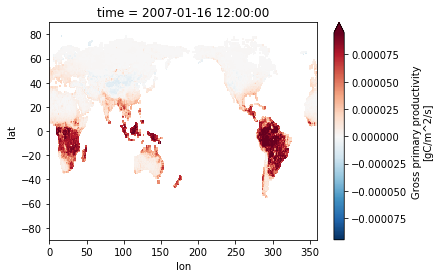

In [5]:
# assign coordinates to time 
# also flip longitude 0-360 & sort by ascending values (as with CLM grids)
# I don't think the lat-lon manipulations are really necessary, but it makes life easier

ds = ds.isel(time=slice(0,months))
ds = ds.assign({'time': (['time'], ds0.time),
                 'lon': (['lon'],xr.where(ds.lon<0, 360+ds.lon, ds.lon))})

ds = ds.sortby('lon', ascending=True)
ds = ds.sortby('lat', ascending=True)
ds['time_bounds'] = ds0.time_bounds #needed for esmlab if we want to calculate climatologies
dr = ds.GPP
dr.isel(time=0).plot(robust=True);
# how does WECAN provide negative GPP values somewhere?

In [ ]:
import cartopy.crs as ccrs

#### -- Output grid -- 

In [6]:
ds_out = xr.Dataset({'lat': (['lat'], ds0.lat),
                     'lon': (['lon'], ds0.lon)})
ds_out

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
Data variables:
    *empty*

In [7]:
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder  # print basic regridder information.
# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.

# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?

Overwrite existing file: bilinear_180x360_192x288.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_180x360_192x288.nc 
Reuse pre-computed weights? False 
Input grid shape:           (180, 360) 
Output grid shape:          (192, 288) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

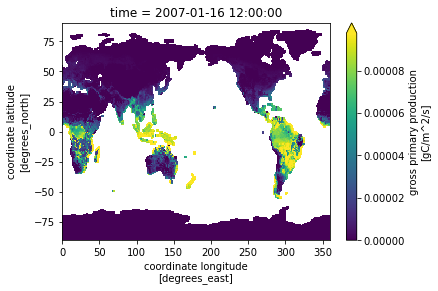

In [9]:
ds0.GPP.isel(time=0).plot(robust=True);
## -- looks like we lost the coastline in this regridding...

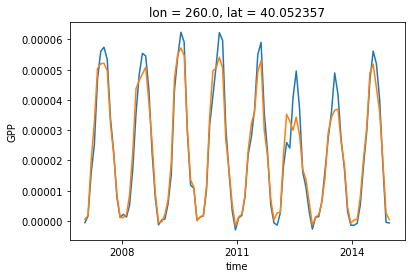

In [10]:
# check results look similar
dr.sel(lon=260, lat=40, method='nearest').plot()      # input data
dr_out.sel(lon=260, lat=40, method='nearest').plot();  # output data

### -- Quick statistics, bias and RMSE w/ plots -- 

In [11]:
ds0['bias'] = xr.DataArray(np.zeros(ds0.GPP.shape), dims=('time','lat', 'lon'))
ds0['bias'][...] = ds0.GPP.values - dr_out.values
# RMSE in setps (1) calculate bias squared (2) take mean over months, (3) square root
mse  = xr.ufuncs.square(ds0.bias).groupby('time.month').mean(dim='time').rename('mse')
rmse = xr.ufuncs.sqrt(mse).rename('RMSE (gC/m2/d)')*3600*24 #convert to gC/m2/d

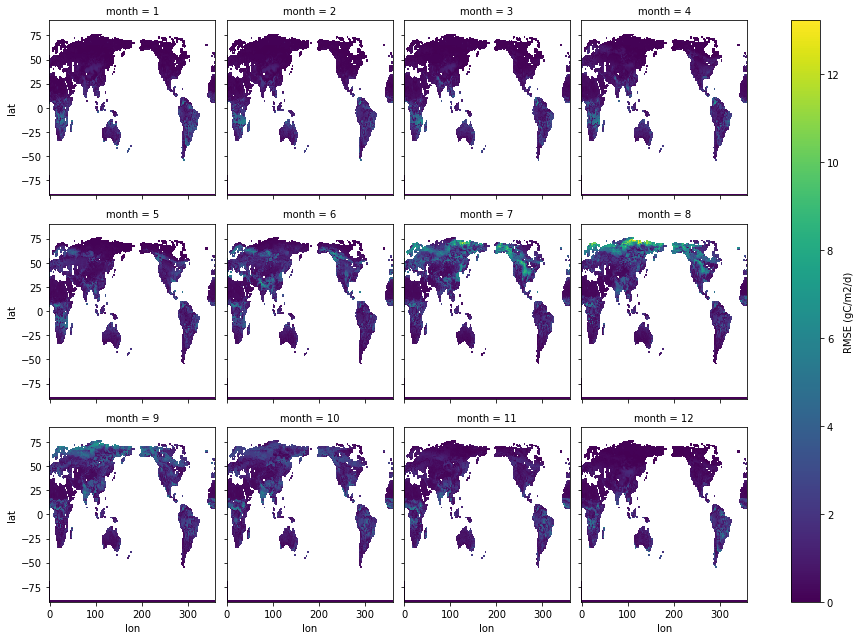

In [12]:
# Quick look at RMSE~month
simple = rmse.plot(x='lon', y='lat', col='month', col_wrap=4)

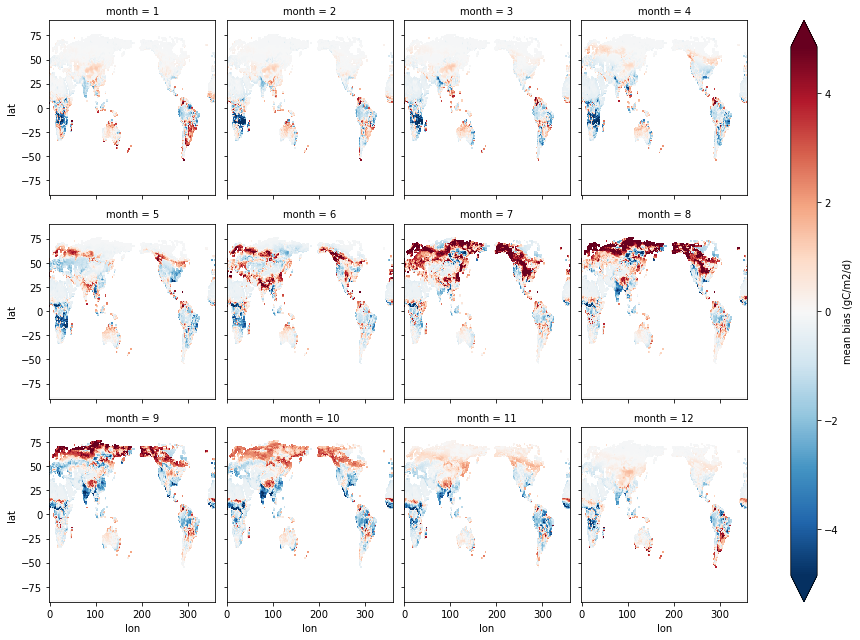

In [13]:
# Bias plots, here averaged for each month
bias = ds0.bias.groupby('time.month').mean(dim='time').rename('mean bias (gC/m2/d)')*3600*24 
bias.plot(x='lon', y='lat', col='month', col_wrap=4, robust=True);

### TODO:
- More useful to look at multiple models
- Calculate global values, seasonal values or timeseries?  How handled in diagnostics or ILAMB?
- Preserve coastlines, does xesmf have tools to help with this?